# Multi-Layer Networks

Now that we have tried our hand at some single-layer nets, let's see how they _stack up_ compared to multi-layer nets.

We will be exploring the basic concepts of learning non-linear functions using the classic XOR problem, and then explore the basics of "deep learning" technology on this problem as well. After that, we will see if a multi-layer approach can perform better than single-layer approach on some data sets that we have seen before. In particular, we will try to explore the wider vs. deeper issue, and see if ReLU really helps.

For now, let's look into the XOR problem, and see what insights we can gain when comparing single- and multi-layer network approaches.

In [1]:
# NN-Tools
import numpy as np
import keras

# Visualization
from IPython.display import SVG
from IPython.display import display
from keras.utils.vis_utils import model_to_dot

# Printing
from sympy import *
init_printing(use_latex=True)

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Let's create the XOR data set. As we mentioned in class, _avoiding zeros_ in the **input** patterns is a good general approach for stable learning behavior.

In [2]:
# XOR data set
X = np.array([[-1,-1],[-1,1],[1,-1],[1,1]])
display(Matrix(X))
Y = np.array([0,1,1,0])
display(Matrix(Y))

⎡-1  -1⎤
⎢      ⎥
⎢-1  1 ⎥
⎢      ⎥
⎢1   -1⎥
⎢      ⎥
⎣1   1 ⎦

⎡0⎤
⎢ ⎥
⎢1⎥
⎢ ⎥
⎢1⎥
⎢ ⎥
⎣0⎦

We are performing a classification task since there are **two discrete targets**, so using **binary cross-entropy** error at the output layer makes sense. Also, binary cross-entropy suggest the **sigmoid** activation function for the **output** unit since it is comparing only two classes. Given that the hyperbolic tangent (tanh) activation function is a decent choice for two-layer networks, let's create a network with a hidden layer consisting of units which use this activation function. Also, we will keep it rather small: just two units.

In [3]:
# Multi-layer net with tanh hidden layer
model = keras.models.Sequential()
model.add(keras.layers.Dense(2,input_dim=2,activation='tanh'))
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
None


Since the input vectors are of length 2, and the hidden layer is of size 2, there will be a 2x2=4 element weight matrix connecting the input layer to the hidden layer. Also, each hidden unit will have a bias weight (6 weights total so far). The hidden to output layer weight matrix will be 2x1=2, and the output unit has its own bias weight as well (total of 9, altogether).

In [4]:
for i in model.get_weights():
    display(Matrix(i))

⎡0.649493   0.0919094⎤
⎢                    ⎥
⎣-0.395286  0.120598 ⎦

⎡0.0⎤
⎢   ⎥
⎣0.0⎦

⎡1.36776⎤
⎢       ⎥
⎣-1.2573⎦

[0.0]

You can see that for tanh units, the bias weight is initialized to zero. We know that zero-element weights can be problematic in some cases, but remember that the bias is **always** used and therefore has access to the full delta for the units. They will only differentiate when required by the task at-hand.

If we want a graph-like representation of our network, we can use some functions from `keras.utils.viz_utils` and the `SVD()` function from `IPython.display` to create such a representation:

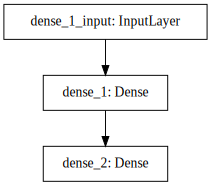

In [5]:
SVG(model_to_dot(model,dpi=70).create(prog='dot', format='svg'))

Not so interesting really for this simple network, but will be more informative for more complex models that we make later in the semester.

Before we get to training, let's see if we can set up a visualization tool that will help us understand how the network is behaving. Simple examples can be very insightful since they can often be investigated more thoroughly than a more complex example, given that the simple example contains the interesting elements that we are looking for.

First, we will create a **meshgrid** of data points (i.e. feature vectors) which _cover_ the space of input vectors for the XOR task thoroughly. This isn't easy to do in a high-dimensional space, since the space requirements grow exponentially with the dimensionality of the input vectors. However, just two dimensions can be visualized and covered with a reasonable number of points.

The `linspace()` function will be used again to create a set of points, now ranging from -2 to 2 (20 distinct values in that range). Next, we use the `meshgrid()` function to create all possible combinations of those values (20x20=400 points!). The `xgrid` and `ygrid` data structures are each 20x20 matrices, where each point we want to visualize will be a combination of corresponding values from each matrix: $\left[ xgrid_{ij}, ygrid_{ij} \right]$ for all i,j. However, this means we need to flatten each of those matrices and combine their corresponding elements into these 2-dimensional vectors. We use a combination of `ravel()` (to perform the flattening) and `vstack()` (to perform the concatenation). The result will actually be the transpose of the final data matrix that we want, so don't forget the `T` at the end.

Now, we will plot all of those data points in green just to show the grid we have made. However, we will also then plot the XOR input vectors (X) colored by their corresponding class labels (0,1), and also a little larger to make them stand out. In this case, red is zero, and blue is one.

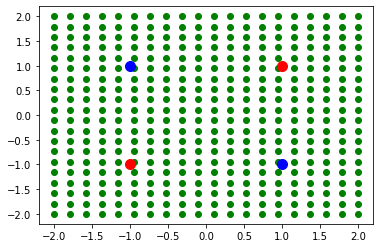

In [6]:
# Sample plot of classification space
xpoints = np.linspace(-2,2,20)
ypoints = np.linspace(-2,2,20)
xgrid, ygrid = np.meshgrid(xpoints,ypoints)
positions = np.vstack([xgrid.ravel(),ygrid.ravel()]).T

# Green grid points where we will evaluate the network
# outputs.
plt.plot(positions[:,0],positions[:,1],'go')

# Color the zero-expected outputs red
plt.plot(X[[0,3],0],X[[0,3],1],'ro',markersize=10)
# Color the one-expected outputs blue
plt.plot(X[[1,2],0],X[[1,2],1],'bo',markersize=10)
plt.show()

Now, let's use this data to visualize how the XOR network behaves. That is, we can use the visualization to examine the current decision boundary that the network is using. You may ask, how could there be a boundary before training? Well, we initialize the weights in the network randomly, so while probably not very useful, the boundary is already there.

For this operation, we need to use the `predict_classes()` function from the model. This is similar to "testing" the neural network, but instead of calculating a loss or accuracy value, we prefer to just see what class label (`predictions`) was assigned to each input vector. We provide all of the grid `positions` calculated above and each one gets assigned to a class of 0 or 1. We can then separate the data into two sets: those input vectors classified as a zero and those input vectors classified as a one. We perform a slice using a boolean operator this time, and then select the matching rows from the `positions` matrix and create two non-overlapping matrices of vectors: `zeros` and `ones`.

Now, rather than coloring them green, we can color them according to the class label that the network _predicted_ for each vector in the grid. By making the XOR vectors a little larger on the plot, it's easy to separate them from the others in the grid as well.

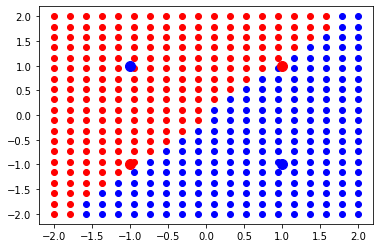

In [7]:
# Let's color those points by the classification labels...
predictions = model.predict_classes(positions)[:,0]
zeros = positions[predictions==0,:]
ones = positions[predictions==1,:]

# Color predictions by class
plt.plot(zeros[:,0],zeros[:,1],'ro')
plt.plot(ones[:,0],ones[:,1],'bo')

# Color the zero-expected outputs red
plt.plot(X[[0,3],0],X[[0,3],1],'ro',markersize=10)
# Color the one-expected outputs blue
plt.plot(X[[1,2],0],X[[1,2],1],'bo',markersize=10)

plt.show()

The grid point covering let's us visualize the decision boundary determined by the network, since the grid points will change from red to blue or vice-versa.

As you can see, the network starts with a suboptimal decision boundary for the task (as expected). Now, let's see if the network can learn to solve the problem.

In [8]:
# Train it!
history = model.fit(X, Y,
    batch_size=1,
    epochs=1000,
    verbose=0)

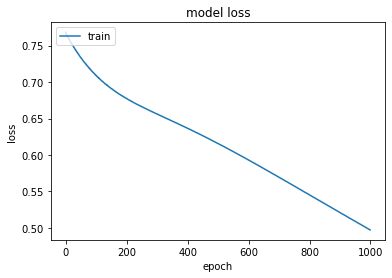

In [9]:
# summarize history for loss  
plt.plot(history.history['loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train'], loc='upper left')  
plt.show()

Now that we have trained the network for a little while, let's see what the network has learned. We can perform the same steps as above, but using predictions from the network _after training_.

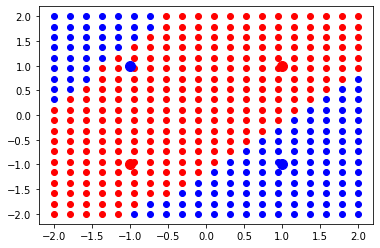

In [10]:
# Let's color those points by the classification labels...
predictions = model.predict_classes(positions)[:,0]
zeros = positions[predictions==0,:]
ones = positions[predictions==1,:]

# Color predictions by class
plt.plot(zeros[:,0],zeros[:,1],'ro')
plt.plot(ones[:,0],ones[:,1],'bo')

# Color the zero-expected outputs red
plt.plot(X[[0,3],0],X[[0,3],1],'ro',markersize=10)
# Color the one-expected outputs blue
plt.plot(X[[1,2],0],X[[1,2],1],'bo',markersize=10)

plt.show()

So, the tanh hidden units were able to provide good boundaries that the output unit could use to decipher the class structure in the data, even in a non-linear manner. If you reinitialized the network weights, you might find that the learned boundary is not always the same. Some problems can be solved in different ways, and therefore different networks may utilize different ways of partitioning the feature space to solve them even if being trained on _the same data_.

## Enter the ReLU

Let's try to see what happens if we utilize our new activation function, ReLU, which we now know has some nice properties for solving complex problems using deeper networks.

The same approach will be used here as was used above, so we will only replace the tanh function with the ReLU activation function. Remember that it has been suggested in the deep learning literature, that initializing the bias on ReLU units to a small positive value for the bias. We will use that technique here to demonstrate how this might work, but it _may not always be a good idea_. Keep that in mind during the exercises below...

In [11]:
# Multi-layer net with ReLU hidden layer
model = keras.models.Sequential()
model.add(keras.layers.Dense(2,input_dim=2,activation='relu',
                             bias_initializer=keras.initializers.Constant(0.1)))
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam')
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
for i in model.get_weights():
    display(Matrix(i))

⎡ -0.7632   0.703291⎤
⎢                   ⎥
⎣-0.748027  0.730599⎦

⎡0.1⎤
⎢   ⎥
⎣0.1⎦

⎡-0.342967⎤
⎢         ⎥
⎣-0.953468⎦

[0.0]

Let's see how this net stacks up to the tanh net using our visualization method above. Remember, we are still _pre-training_ here for this network.

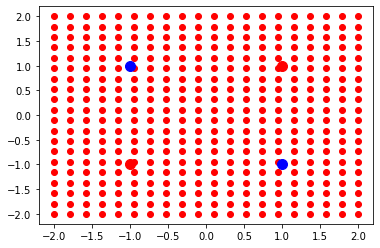

In [13]:
# Let's color those points by the classification labels...
predictions = model.predict_classes(positions)[:,0]
zeros = positions[predictions==0,:]
ones = positions[predictions==1,:]

# Color predictions by class
plt.plot(zeros[:,0],zeros[:,1],'ro')
plt.plot(ones[:,0],ones[:,1],'bo')

# Color the zero-expected outputs red
plt.plot(X[[0,3],0],X[[0,3],1],'ro',markersize=10)
# Color the one-expected outputs blue
plt.plot(X[[1,2],0],X[[1,2],1],'bo',markersize=10)

plt.show()

Sometimes, we will see a boundary, but with other weights we may not. Let's see if some training pushes that boundary into the visible space of input vectors...

In [14]:
# Train it!
history = model.fit(X, Y,
    batch_size=1,
    epochs=1000,
    verbose=0)

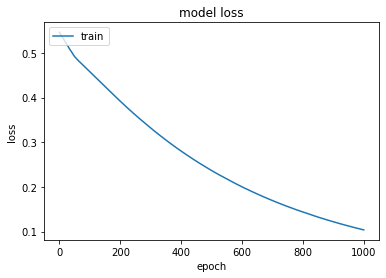

In [15]:
# summarize history for loss  
plt.plot(history.history['loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train'], loc='upper left')  
plt.show()

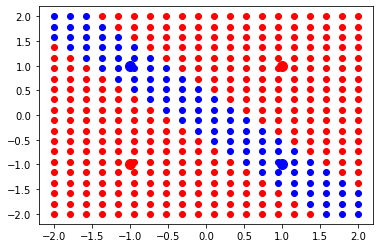

In [16]:
# Let's color those points by the classification labels...
predictions = model.predict_classes(positions)[:,0]
zeros = positions[predictions==0,:]
ones = positions[predictions==1,:]

# Color predictions by class
plt.plot(zeros[:,0],zeros[:,1],'ro')
plt.plot(ones[:,0],ones[:,1],'bo')

# Color the zero-expected outputs red
plt.plot(X[[0,3],0],X[[0,3],1],'ro',markersize=10)
# Color the one-expected outputs blue
plt.plot(X[[1,2],0],X[[1,2],1],'bo',markersize=10)

plt.show()

Well, that's not very promising is it? Is ReLU that useful after-all? What might be the problem here?

We've seen how to train a multilayer network using both tanh and ReLU at least, even if the results are not very spectacular. However, you should have some intuition about how this problem might be rectified using some hints on the slides and what we have talked about in class...

## Classifying MNIST

The MNIST data set consists of 60,000 images of handwritten digits for training and 10,000 images of handwritten digits for testing. We looked at this data in our last homework assignment some, but now we will try to train up a network for classifying these images.

First, let's load the data and prepare it for presentation to a network.

In [17]:
from keras.datasets import mnist

# Digits are zero through nine, so 10 classes
num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows * img_cols)
x_test = x_test.reshape(x_test.shape[0], img_rows * img_cols)

# Data normalization (0-255 is encoded as 0-1 instead)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Shape information
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 784)
y_train shape: (60000, 10)
60000 train samples
10000 test samples


You can see that we have flattened each image (28x28 pixels) into a 728-element vector using the `reshape()` function. The intensity values in the original data are in the range 0-255, but we divide them all by 255 in order to scale the intensity between 0 and 1. This just keeps us from starting at extreme values in the weight space (where tanh and sigmoid get stuck easily). Finally, we convert the integer class labels (originally just 0,1,2,...,9) into the categorical representation that we need for `categorical cross-entropy`.

OK, so we need to train a network to recognize these digits. We will fully utilize the training/validation data alone when tuning parameters, and run a final accuracy check on the _test_ data which was _never seen_ during the training process. Let's see what a single-layer network can do to start with...

In [18]:
model = keras.models.Sequential()

# Linear
model.add(keras.layers.Dense(num_classes, activation='softmax',input_shape=[x_train.shape[1]]))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Train it!
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=30,
          verbose=1,
          validation_split = 0.2)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 3s 60us/step - loss: 0.7537 - accuracy: 0.8177 - val_loss: 0.4096 - val_accuracy: 0.8927
Epoch 2/30
48000/48000 [==============================] - 2s 50us/step - loss: 0.3890 - accuracy: 0.8972 - val_loss: 0.3351 - val_accuracy: 0.9090
Epoch 3/30
48000/48000 [==============================] - 3s 57us/step - loss: 0.3379 - accuracy: 0.9078 - val_loss: 0.3078 - val_accuracy: 0.9171
Epoch 4/30
48000/48000 [==============================] - 3s 55us/step - loss: 0.3143 - accuracy: 0.9129 - val_loss: 0.2945 - val_accuracy: 0.9177
Epoch 5/30
48000/48000 [==============================] - 2s 48us/step - loss: 0.3001 - accuracy: 0.9171 - val_loss: 0.2859 - val_accuracy: 0.9212
Epoch 6/30
48000/48000 [==============================] - 3s 52us/step - loss: 0.2903 - accuracy: 0.9196 - val_loss: 0.2804 - val_accuracy: 0.9226
Epoch 7/30
48000/48000 [==============================] - 2s 52us/st

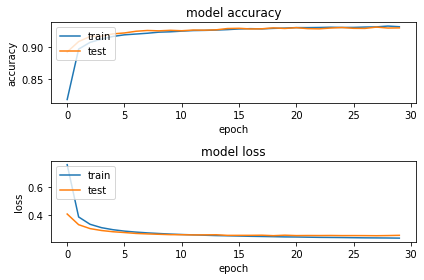

In [20]:
plt.figure()  
   
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')

plt.tight_layout()
plt.show()  

Excellent! Let's take one more look at that accuracy...

In [21]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.26687900473475457
Test accuracy: 0.925599992275238


Just a single layer network is capable of performing above 92% accuracy on examples that it has never even seen during training. So, the gauntlet has been thown: can a deeper net do better? It will take some modifications to the architecture (tuning the *inductive bias*) in order to get there...